<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-Libraries" data-toc-modified-id="Loading-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading Libraries</a></span></li><li><span><a href="#Reading-the-dicom-image" data-toc-modified-id="Reading-the-dicom-image-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading the dicom image</a></span></li><li><span><a href="#Displaying-the-dicom-image-before-converting-to-hounsfield-units" data-toc-modified-id="Displaying-the-dicom-image-before-converting-to-hounsfield-units-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Displaying the dicom image before converting to hounsfield units</a></span></li><li><span><a href="#Hounsfield-value-chart" data-toc-modified-id="Hounsfield-value-chart-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hounsfield value chart</a></span></li><li><span><a href="#Converting-values-to-hounsfield-units" data-toc-modified-id="Converting-values-to-hounsfield-units-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Converting values to hounsfield units</a></span></li><li><span><a href="#Creating-an-internal-marker" data-toc-modified-id="Creating-an-internal-marker-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Creating an internal marker</a></span></li><li><span><a href="#Generating-original-image-from-the-internal-marker-mask" data-toc-modified-id="Generating-original-image-from-the-internal-marker-mask-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Generating original image from the internal marker mask</a></span></li><li><span><a href="#Creating-External-marker" data-toc-modified-id="Creating-External-marker-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Creating External marker</a></span></li><li><span><a href="#Creating-a-watershed-marker" data-toc-modified-id="Creating-a-watershed-marker-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Creating a watershed marker</a></span></li><li><span><a href="#Applying-Sobel-edge-detector" data-toc-modified-id="Applying-Sobel-edge-detector-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Applying Sobel edge detector</a></span></li><li><span><a href="#Applying-watershed-segmentation-for-generating-the-lung-mask" data-toc-modified-id="Applying-watershed-segmentation-for-generating-the-lung-mask-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Applying watershed segmentation for generating the lung mask</a></span></li><li><span><a href="#Finding-outline-of-the-lung-mask" data-toc-modified-id="Finding-outline-of-the-lung-mask-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Finding outline of the lung mask</a></span></li><li><span><a href="#Re-creating-mask-with-bitwise-or" data-toc-modified-id="Re-creating-mask-with-bitwise-or-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Re-creating mask with bitwise or</a></span></li><li><span><a href="#Generating-image-from-the-mask" data-toc-modified-id="Generating-image-from-the-mask-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Generating image from the mask</a></span></li><li><span><a href="#Watershed-segmentation" data-toc-modified-id="Watershed-segmentation-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Watershed segmentation</a></span></li><li><span><a href="#Generating-segmented-images-from-Hounsfield-values-and-watershed-markers" data-toc-modified-id="Generating-segmented-images-from-Hounsfield-values-and-watershed-markers-16"><span class="toc-item-num">16&nbsp;&nbsp;</span>Generating segmented images from Hounsfield values and watershed markers</a></span></li><li><span><a href="#Generating-segmented-images-from-original-dicom-values-and-watershed-markers" data-toc-modified-id="Generating-segmented-images-from-original-dicom-values-and-watershed-markers-17"><span class="toc-item-num">17&nbsp;&nbsp;</span>Generating segmented images from original dicom values and watershed markers</a></span></li><li><span><a href="#Generating-Haralick-Texture-Features" data-toc-modified-id="Generating-Haralick-Texture-Features-18"><span class="toc-item-num">18&nbsp;&nbsp;</span>Generating Haralick Texture Features</a></span></li></ul></div>

# Loading Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import cv2 as cv
import os
from skimage import measure, morphology, segmentation
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import scipy.ndimage as ndimage
import pydicom
import plotly.graph_objects as go
from mpl_toolkits import mplot3d
from skimage.measure import shannon_entropy
import math
from scipy.stats import entropy
from skimage.feature import greycomatrix, greycoprops
import pandas as pd

#For further processing, intensity = -2000 is assigned for background 

# Reading the dicom image

In [2]:
dicom_file = pydicom.dcmread('/Users/rt/Desktop/College/4th year/sem 7/Project/Literature survey/Dicom/dicom/dicom_dir/ID_0000_AGE_0060_CONTRAST_1_CT.dcm')

# Displaying the dicom image before converting to hounsfield units

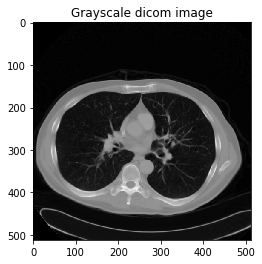

Pixel range before converting to Hounsfield unit
Max value :  1918
Min value :  0


In [3]:
#converting to pixel array
image = dicom_file.pixel_array
image = image.astype(np.uint16)

#storing the grid size for 3d plot
x, y = np.mgrid[0:image.shape[0], 0:image.shape[1]]

plt.imshow(image, cmap = 'gray')
plt.title('Grayscale dicom image')
plt.show()
print('Pixel range before converting to Hounsfield unit')
print('Max value : ',np.max(image))
print('Min value : ',np.min(image))

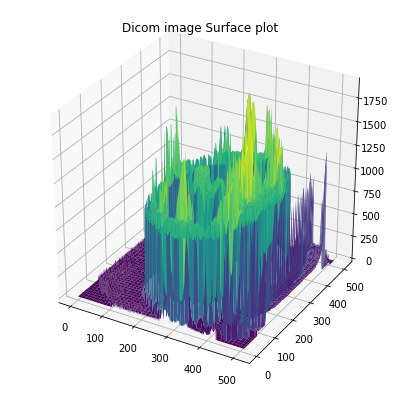

In [4]:
#Surface plot for original dicom image
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, image, cmap='viridis', edgecolor='none')
ax.set_title('Dicom image Surface plot ')
plt.show()

# Hounsfield value chart

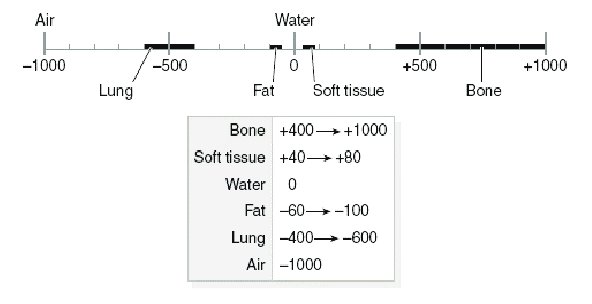

# Converting values to hounsfield units

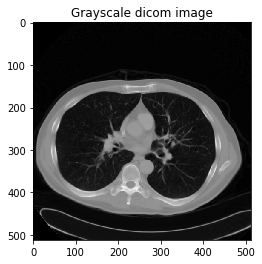

Pixel range After converting to Hounsfield unit
Max value :  894
Min value :  -1024


In [5]:
image_h = image
image_h[image_h == -2000] = 0
intercept = dicom_file.RescaleIntercept
slope = dicom_file.RescaleSlope

if slope != 1:
    image_h = slope * image.astype(np.float64)
    image_h = image.astype(np.int16)

image_h = image_h + np.int16(intercept)
test_patient_images = np.array(image_h, dtype = np.int16)

plt.imshow(test_patient_images,cmap = 'gray')
plt.title('Grayscale dicom image')
plt.show()

print('Pixel range After converting to Hounsfield unit')
print('Max value : ',np.max(image_h))
print('Min value : ',np.min(image_h))

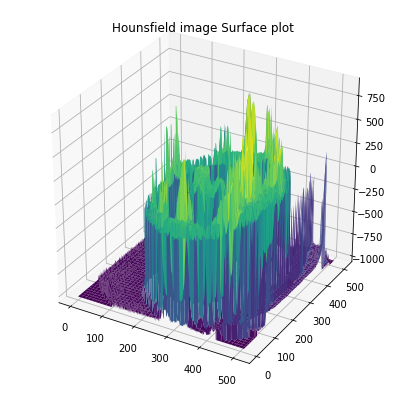

In [6]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, image_h, cmap='viridis', edgecolor='none')
ax.set_title('Hounsfield image Surface plot')
plt.show()

# Creating an internal marker

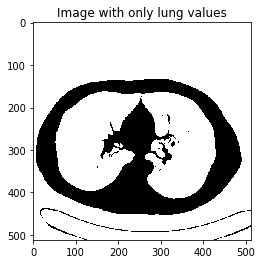

Pixel range
Max value :  True
Min value :  False


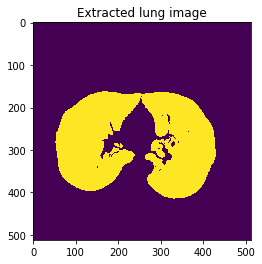

Pixel range
Max value :  True
Min value :  False


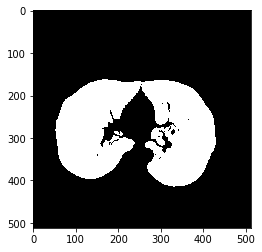

Pixel range
Max value :  True
Min value :  False


In [7]:
#for hounsfield values, lung values ranges < -400
#boolean values to be stored 

marker_internal = image_h < -400
plt.imshow(marker_internal, cmap = 'gray')
plt.title('Image with only lung values')
plt.show()
print('Pixel range')
print('Max value : ',np.max(marker_internal))
print('Min value : ',np.min(marker_internal))


#extracting only the lung region
marker_internal = segmentation.clear_border(marker_internal)
plt.imshow(marker_internal)
plt.title('Extracted lung image')
plt.show()
print('Pixel range')
print('Max value : ',np.max(marker_internal))
print('Min value : ',np.min(marker_internal))

marker_internal_labels = measure.label(marker_internal)
areas = [r.area for r in measure.regionprops(marker_internal_labels)]
areas.sort()
if len(areas) > 2:
    for region in measure.regionprops(marker_internal_labels):
        if region.area < areas[-2]:
            for coordinates in region.coords:
                marker_internal_labels[coordinates[0],coordinates[1]] = 0

marker_internal = marker_internal_labels > 0
plt.imshow(marker_internal,cmap = 'gray')
plt.show()
print('Pixel range')
print('Max value : ',np.max(marker_internal))
print('Min value : ',np.min(marker_internal))

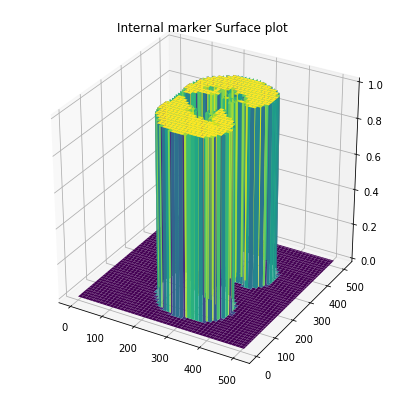

In [8]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, marker_internal, cmap='viridis', edgecolor='none')
ax.set_title('Internal marker Surface plot')
plt.show()

# Generating original image from the internal marker mask

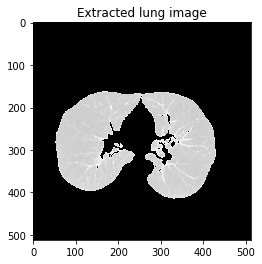

Pixel range
Max value :  623.0
Min value :  -2000.0


In [9]:
lung_image = np.where(marker_internal == 1, image, -2000*np.ones((512,512)))
plt.imshow(lung_image, cmap = 'gray')
plt.title('Extracted lung image')
plt.show()
print('Pixel range')
print('Max value : ',np.max(lung_image))
print('Min value : ',np.min(lung_image))

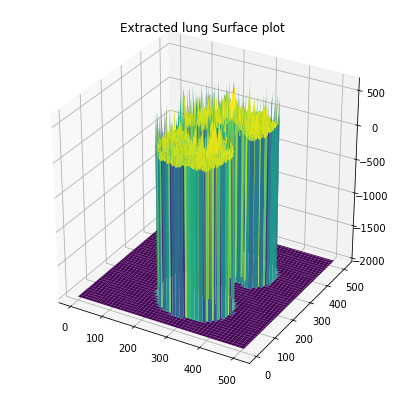

In [10]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, lung_image, cmap='viridis', edgecolor='none')
ax.set_title('Extracted lung Surface plot')
plt.show()

# Creating External marker

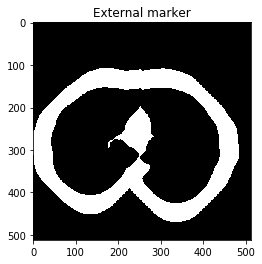

Pixel range
Max value :  True
Min value :  False


In [11]:
external_a = ndimage.binary_dilation(marker_internal, iterations = 10)
external_b = ndimage.binary_dilation(marker_internal, iterations = 55)
plt.imshow(external_a)
plt.imshow(external_b)
marker_external = external_b ^ external_a
plt.imshow(marker_external,cmap = 'gray')
plt.title('External marker')
plt.show()
print('Pixel range')
print('Max value : ',np.max(marker_external))
print('Min value : ',np.min(marker_external))

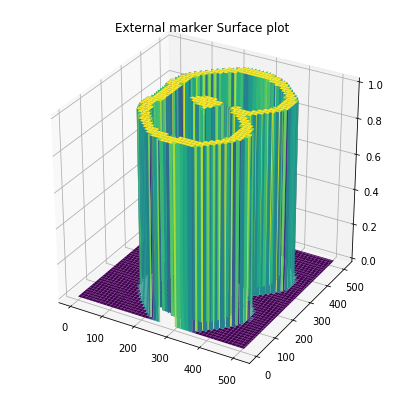

In [12]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, marker_external, cmap='viridis', edgecolor='none')
ax.set_title('External marker Surface plot')
plt.show()

# Creating a watershed marker

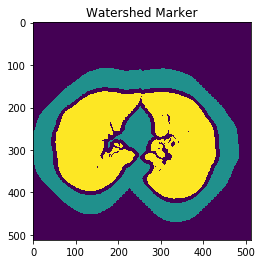

Pixel range
Max value :  255.0
Min value :  0.0


In [13]:
#creating a watershed marker from the internal & external marker
marker_watershed = np.zeros((512,512), dtype = np.uint)
marker_watershed = marker_watershed + marker_internal * 255
marker_watershed = marker_watershed + marker_external * 128
plt.imshow(marker_watershed)
plt.title('Watershed Marker')
plt.show()
print('Pixel range')
print('Max value : ',np.max(marker_watershed))
print('Min value : ',np.min(marker_watershed))

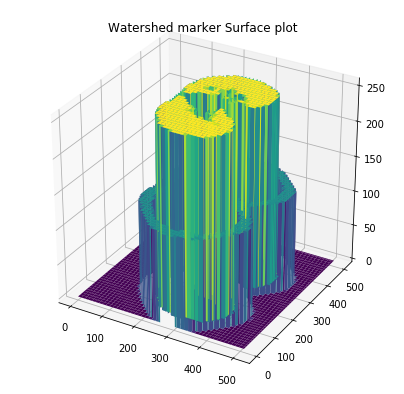

In [14]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, marker_watershed, cmap='viridis', edgecolor='none')
ax.set_title('Watershed marker Surface plot')
plt.show()

# Applying Sobel edge detector

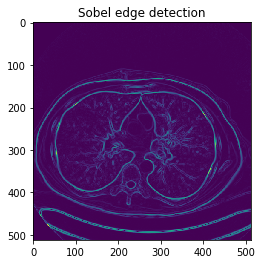

Pixel range
Max value :  255.0
Min value :  0.0


In [15]:
sobel_filtered_dx = ndimage.sobel(image_h, 1)
sobel_filtered_dy = ndimage.sobel(image_h, 0)
sobel_gradient = np.hypot(sobel_filtered_dx,sobel_filtered_dy)
sobel_gradient = sobel_gradient * 255 / np.max(sobel_gradient)
plt.imshow(sobel_gradient)
plt.title('Sobel edge detection')
plt.show()
print('Pixel range')
print('Max value : ',np.max(sobel_gradient))
print('Min value : ',np.min(sobel_gradient))

# Applying watershed segmentation for generating the lung mask

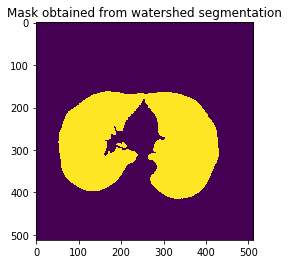

Pixel range
Max value :  255
Min value :  128


In [16]:
watershed = morphology.watershed(sobel_gradient, marker_watershed)
plt.imshow(watershed)
plt.title('Mask obtained from watershed segmentation')
plt.show()
print('Pixel range')
print('Max value : ',np.max(watershed))
print('Min value : ',np.min(watershed))

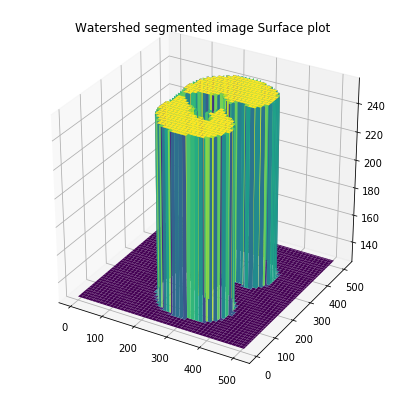

In [17]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, watershed, cmap='viridis', edgecolor='none')
ax.set_title('Watershed segmented image Surface plot')
plt.show()

# Finding outline of the lung mask

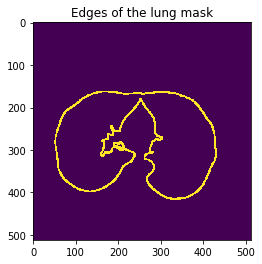

Pixel range
Max value :  True
Min value :  False


In [18]:
outline = ndimage.morphological_gradient(watershed, size = (5,5))
outline = outline.astype(bool)
plt.imshow(outline)
plt.title('Edges of the lung mask')
plt.show()
print('Pixel range')
print('Max value : ',np.max(outline))
print('Min value : ',np.min(outline))

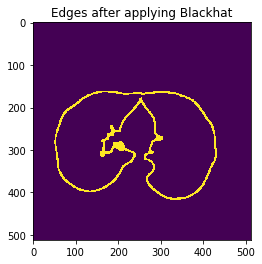

Pixel range
Max value :  True
Min value :  False


In [19]:
#applying blackhat filter for image enhancement

blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                   [0, 1, 1, 1, 1, 1, 0],
                   [1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1],
                   [0, 1, 1, 1, 1, 1, 0],
                   [0, 0, 1, 1, 1, 0, 0]]

blackhat_struct = ndimage.iterate_structure(blackhat_struct, 1)
outline += ndimage.black_tophat(outline, structure=blackhat_struct)
plt.imshow(outline)
plt.title('Edges after applying Blackhat')
plt.show()
print('Pixel range')
print('Max value : ',np.max(outline))
print('Min value : ',np.min(outline))

# Re-creating mask with bitwise or

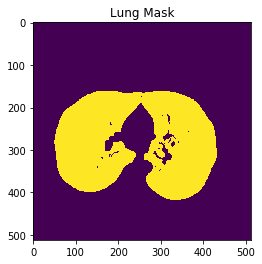

Pixel range
Max value :  True
Min value :  False


In [20]:
lungfilter = np.bitwise_or(marker_internal, outline)
plt.imshow(lungfilter)
plt.title('Lung Mask')
plt.show()

print('Pixel range')
print('Max value : ',np.max(lungfilter))
print('Min value : ',np.min(lungfilter))

# Generating image from the mask

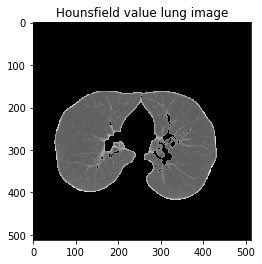

Pixel range
Max value :  894.0
Min value :  -2000.0


In [21]:
segmented = np.where(lungfilter == 1, image_h, -2000*np.ones((512,512)))
plt.imshow(segmented,cmap = 'gray')
plt.title('Hounsfield value lung image')
plt.show()

print('Pixel range')
print('Max value : ',np.max(segmented))
print('Min value : ',np.min(segmented))

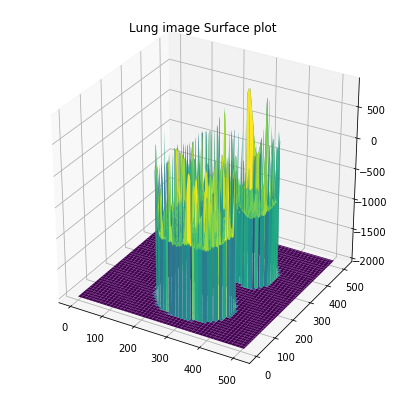

In [22]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, segmented, cmap='viridis', edgecolor='none')
ax.set_title('Lung image Surface plot')
plt.show()

# Watershed segmentation

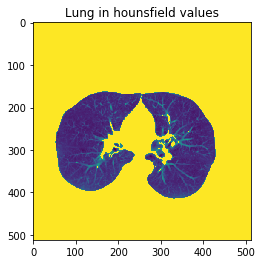

Pixel range
Max value :  0.0
Min value :  -1001.0


In [23]:
#Obtaining image from the internal marker
lung_filter = np.where(marker_internal == 1, image_h, np.zeros((512,512)))
plt.imshow(lung_filter)
plt.title('Lung in hounsfield values')
plt.show()

print('Pixel range')
print('Max value : ',np.max(lung_filter))
print('Min value : ',np.min(lung_filter))

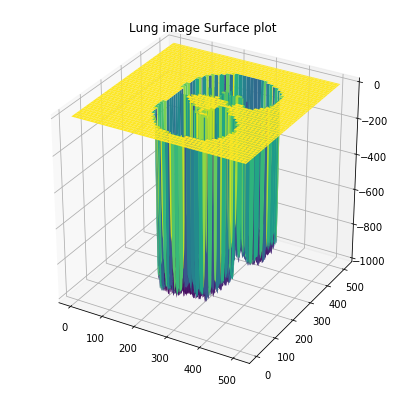

In [24]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, lung_filter, cmap='viridis', edgecolor='none')
ax.set_title('Lung image Surface plot')
plt.show()

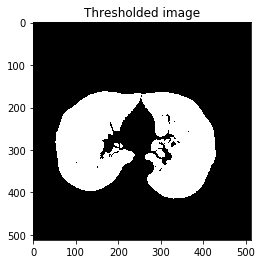

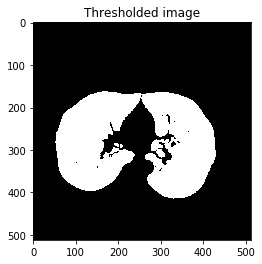

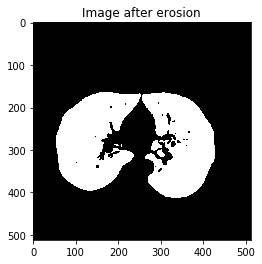

In [25]:
#Normalization
normalized = cv.normalize(lung_filter, lung_filter, 0, 255, cv.NORM_MINMAX)

#Thresholding using Otsu's method
ret, thresh = cv.threshold(np.uint8(normalized),0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plt.imshow(thresh, cmap = 'gray')
plt.title('Thresholded image')
plt.show()

#Using opening morphological operation
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 1)
plt.imshow(opening,cmap = 'gray')
plt.title('Thresholded image')
plt.show()

#Using Erosion morphological operation
fg = cv.erode(opening, np.ones((3,3)))
plt.imshow(fg,cmap = 'gray')
plt.title('Image after erosion')
plt.show()

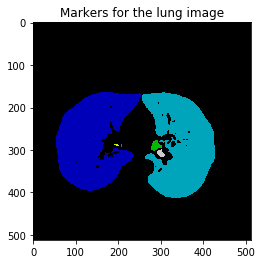

In [26]:
#Generating markers for watershed segmentation
ret, markers = cv.connectedComponents(fg)
markers = markers + 1
plt.imshow(markers, cmap = 'nipy_spectral')
plt.title('Markers for the lung image')
plt.show()

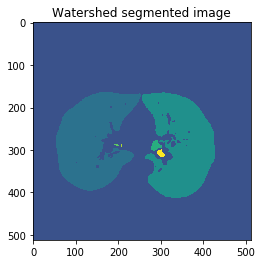

In [27]:
#Converting image to RGB (As function watershed needs a 3 channel input image)
rgb = cv.cvtColor(np.uint8(normalized), cv.COLOR_GRAY2RGB)

#watershed segmentation
watershed_seg = cv.watershed(np.uint8(rgb), markers)
plt.imshow(watershed_seg)
plt.title('Watershed segmented image')
plt.show()

# Generating segmented images from Hounsfield values and watershed markers

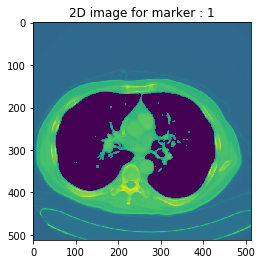

Pixel range
Max value :  894.0
Min value :  -2000.0


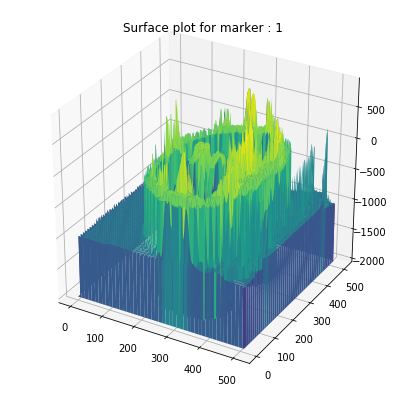

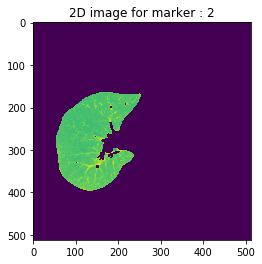

Pixel range
Max value :  -441.0
Min value :  -2000.0


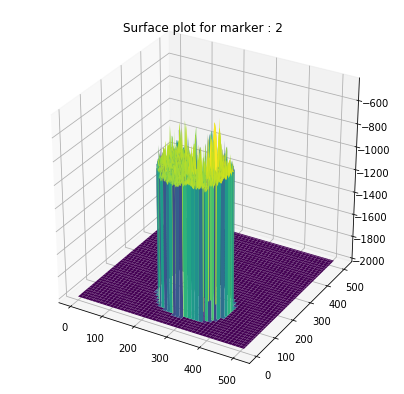

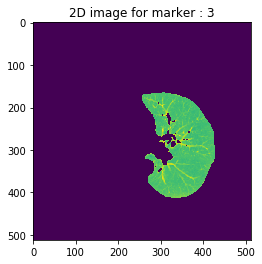

Pixel range
Max value :  -423.0
Min value :  -2000.0


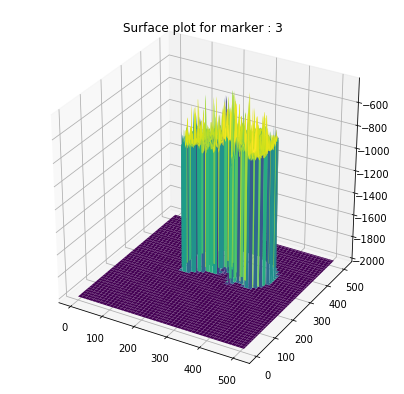

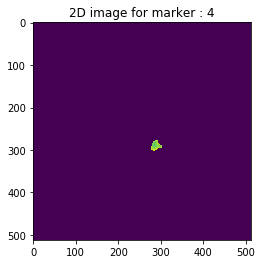

Pixel range
Max value :  -482.0
Min value :  -2000.0


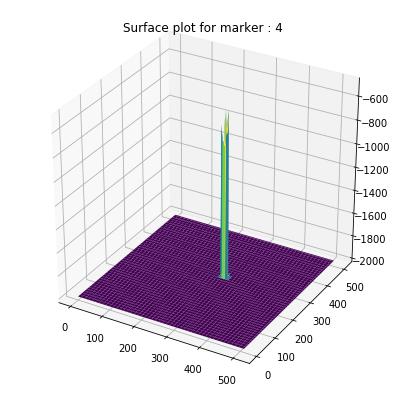

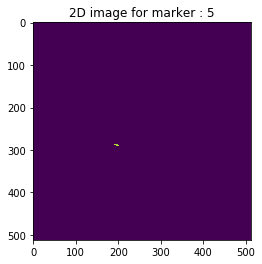

Pixel range
Max value :  -632.0
Min value :  -2000.0


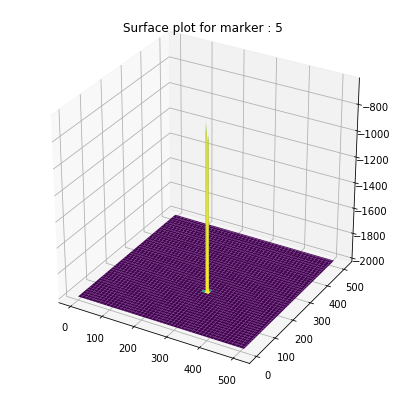

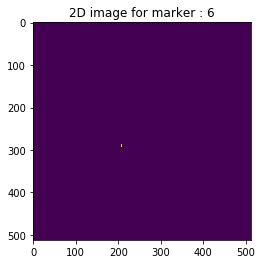

Pixel range
Max value :  -489.0
Min value :  -2000.0


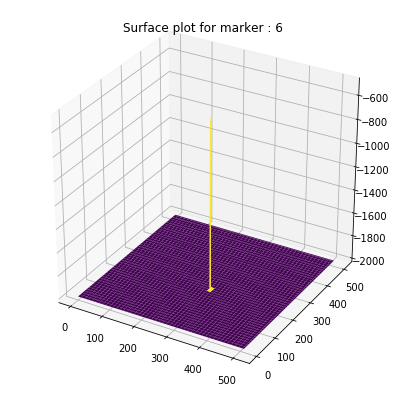

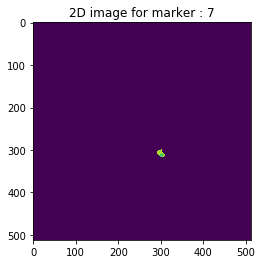

Pixel range
Max value :  -481.0
Min value :  -2000.0


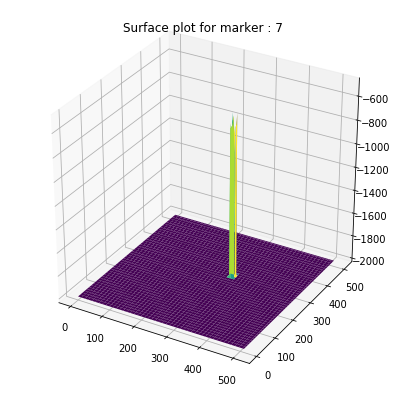

In [28]:
m = {}
for i in range(np.min(watershed_seg)+2, np.max(watershed_seg) + 1):
    #generating image wrt the marker
    temp = np.where(watershed_seg == i, image_h, -2000*np.ones((512,512)))
    m[i] = temp
    plt.imshow(temp)
    #2D image plot
    plt.title('2D image for marker : %i'%i)
    plt.show()
    print('Pixel range')
    print('Max value : ',np.max(temp))
    print('Min value : ',np.min(temp))
    
    #Surface plot
    fig = plt.figure(figsize = (7,7))
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, temp, cmap='viridis', edgecolor='none')
    ax.set_title('Surface plot for marker : %i'%i)
    plt.show()
    

# Generating segmented images from original dicom values and watershed markers

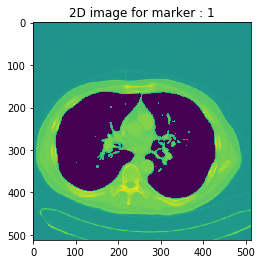

Pixel range
Max value :  1918.0
Min value :  -2000.0


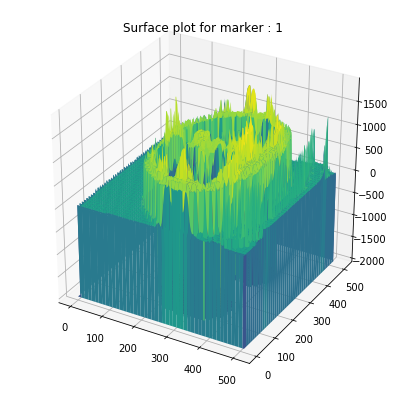

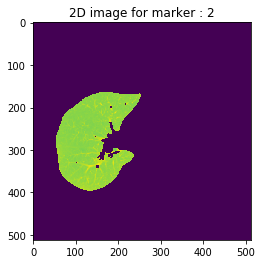

Pixel range
Max value :  583.0
Min value :  -2000.0


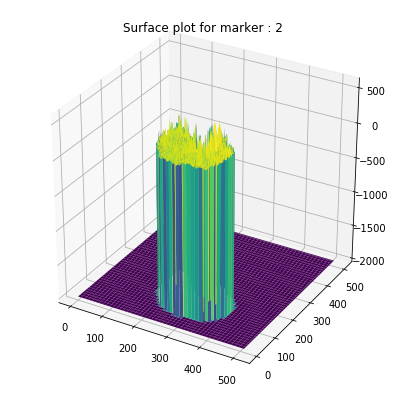

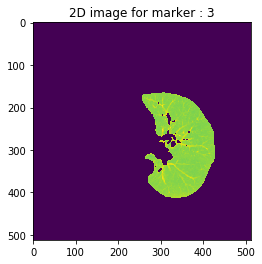

Pixel range
Max value :  601.0
Min value :  -2000.0


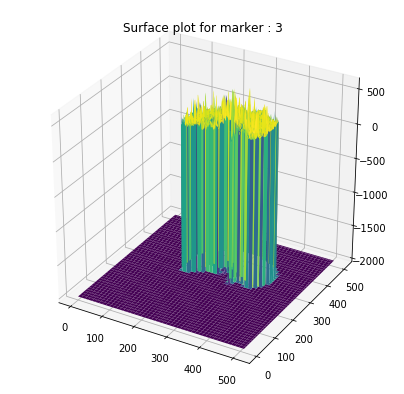

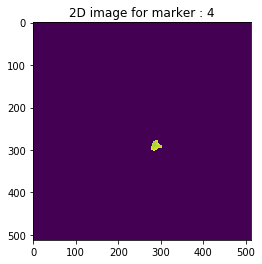

Pixel range
Max value :  542.0
Min value :  -2000.0


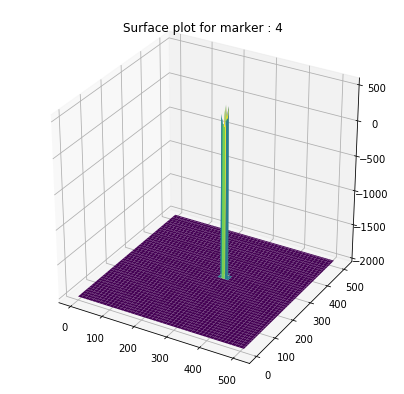

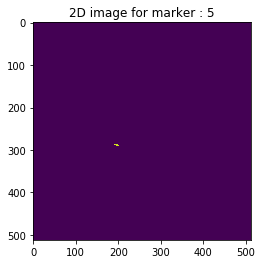

Pixel range
Max value :  392.0
Min value :  -2000.0


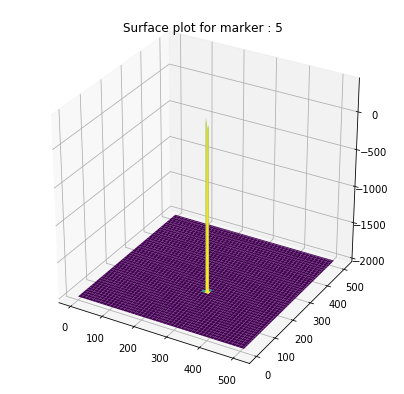

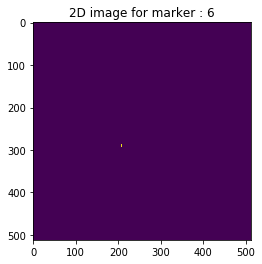

Pixel range
Max value :  535.0
Min value :  -2000.0


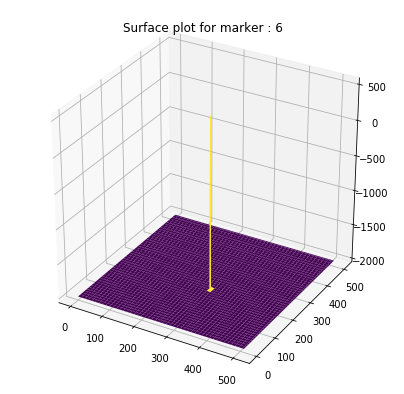

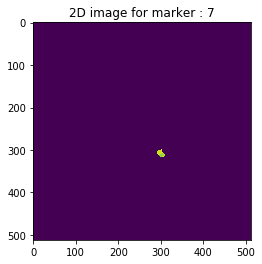

Pixel range
Max value :  543.0
Min value :  -2000.0


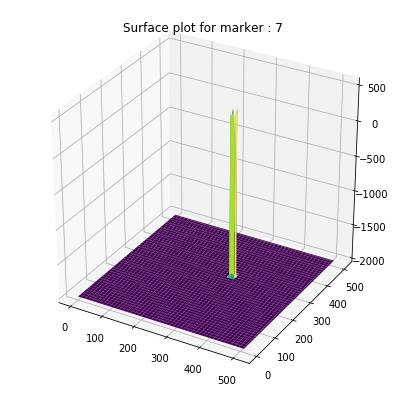

In [29]:
d = {}
for i in range(np.min(watershed_seg)+2, np.max(watershed_seg) + 1):
    
    #generating image wrt the marker
    temp = np.where(watershed_seg == i, image, -2000*np.ones((512,512)))
    d[i] = temp
    plt.imshow(temp)
    
    #2D image plot
    plt.title('2D image for marker : %i'%i)
    plt.show()
    print('Pixel range')
    print('Max value : ',np.max(temp))
    print('Min value : ',np.min(temp))
    
    #Surface plot
    fig = plt.figure(figsize = (7,7))
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, temp, cmap='viridis', edgecolor='none')
    ax.set_title('Surface plot for marker : %i'%i)
    plt.show()

# Generating Haralick Texture Features

In [30]:
#Calculating texture features for the following offsets:
offsets = [1, 2, 3]
    
#Calculating texture features for the following Angles:
angles = [0, np.pi/4 ,np.pi/2, 3*np.pi/4]

angles_s = ['0', '45', '90', '135']

In [31]:
def flatten(feature):
    l = [item for sublist in feature for item in sublist]
    return l

In [32]:
def Haralick_Textures(img, t):
    #Calculating texture features for the following offsets:
    offsets = [1, 2, 3]
    
    #Calculating texture features for the following Angles:
    angles = [0, np.pi/4 ,np.pi/2, 3*np.pi/4]
    
    angles_s = ['0', '45', '90', '135']
    g = greycomatrix(img, offsets, angles)
    
    d = []
    for i in offsets:
        for j in angles_s:
            s = '{} (d = {})'.format(j, i)
            d.append(s)
    
    df_texture_values = pd.DataFrame(d, columns = ['Angles & Distance'])
    
    #calculating contrast from GLCM
    contrast = greycoprops(g, 'contrast')
    contrast_flatten = flatten(contrast)
    df_texture_values['Contrast'] = contrast_flatten
    df_texture_values.set_index('Angles & Distance', inplace = True)
    
    #calculating dissimilarity from GLCM
    dissimilarity = greycoprops(g, 'dissimilarity')
    dissimilarity_flatten = flatten(dissimilarity)
    df_texture_values['Dissimilarity'] = dissimilarity_flatten
    
    #calculating homogeneity from GLCM
    homogeneity = greycoprops(g, 'homogeneity')
    homogeneity_flatten = flatten(homogeneity)
    df_texture_values['Homogeneity'] = homogeneity_flatten
    
    #calculating ASM from GLCM
    ASM = greycoprops(g, 'ASM')
    ASM_flatten = flatten(ASM)
    df_texture_values['ASM'] = ASM_flatten
    
    #calculating Energy from GLCM
    energy = greycoprops(g, 'energy')
    energy_flatten = flatten(energy)
    df_texture_values['Energy'] = energy_flatten
    
    #calculating Correlation from GLCM
    correlation = greycoprops(g, 'correlation')
    correlation_flatten = flatten(correlation)
    df_texture_values['Correlation'] = correlation_flatten
    
    display(df_texture_values)
    df_texture_values.to_csv ('/Users/rt/Desktop/College/4th year/sem 7/Project/code/Texture_Features/segment_{}.csv'.format(t), header=True)
    
    #calculating entropy from GLCM
    entropy = shannon_entropy(img)
    print('Entropy : ', entropy)

In [33]:
Haralick_Textures(np.uint8(d[1]), 1)

,Contrast,Dissimilarity,Homogeneity,ASM,Energy,Correlation
Angles & Distance,,,,,,
0 (d = 1),1683.819923,17.151931,0.331944,0.051241,0.226365,0.762110
45 (d = 1),2021.223923,20.022181,0.317736,0.049038,0.221445,0.714931
90 (d = 1),1880.660707,19.152963,0.322239,0.051249,0.226383,0.734300
135 (d = 1),2020.096017,20.064537,0.316623,0.049158,0.221716,0.715090
0 (d = 2),2132.072047,20.338829,0.321228,0.050055,0.223731,0.698919
45 (d = 2),2021.223923,20.022181,0.317736,0.049038,0.221445,0.714931
90 (d = 2),2362.527325,22.675080,0.315636,0.050068,0.223760,0.666276
135 (d = 2),2020.096017,20.064537,0.316623,0.049158,0.221716,0.715090
0 (d = 3),2451.664009,23.182189,0.310781,0.048851,0.221022,0.653955


Entropy :  6.431267514137457


In [34]:
Haralick_Textures(np.uint8(d[2]), 1)

,Contrast,Dissimilarity,Homogeneity,ASM,Energy,Correlation
Angles & Distance,,,,,,
0 (d = 1),313.348604,3.046477,0.894390,0.784734,0.885852,0.876446
45 (d = 1),388.209987,3.834360,0.891348,0.782752,0.884733,0.847196
90 (d = 1),309.012521,3.029920,0.894020,0.784660,0.885810,0.878155
135 (d = 1),376.354954,3.726135,0.891808,0.783768,0.885307,0.851863
0 (d = 2),436.290587,4.380806,0.889702,0.782094,0.884361,0.828272
45 (d = 2),388.209987,3.834360,0.891348,0.782752,0.884733,0.847196
90 (d = 2),440.774877,4.412485,0.889526,0.781945,0.884276,0.826507
135 (d = 2),376.354954,3.726135,0.891808,0.783768,0.885307,0.851863
0 (d = 3),502.338577,5.077580,0.887156,0.779508,0.882898,0.802623


Entropy :  1.3447996337008532


In [35]:
Haralick_Textures(np.uint8(d[3]), 2)

,Contrast,Dissimilarity,Homogeneity,ASM,Energy,Correlation
Angles & Distance,,,,,,
0 (d = 1),323.894363,3.233565,0.898256,0.793991,0.891062,0.861130
45 (d = 1),391.882277,3.944891,0.895859,0.792724,0.890351,0.832277
90 (d = 1),331.295316,3.260970,0.898005,0.794168,0.891161,0.857956
135 (d = 1),395.302683,3.933487,0.895623,0.792240,0.890079,0.830813
0 (d = 2),450.185884,4.559206,0.894084,0.790883,0.889316,0.807324
45 (d = 2),391.882277,3.944891,0.895859,0.792724,0.890351,0.832277
90 (d = 2),453.859812,4.558816,0.894146,0.791196,0.889492,0.805751
135 (d = 2),395.302683,3.933487,0.895623,0.792240,0.890079,0.830813
0 (d = 3),513.790759,5.230607,0.891298,0.787797,0.887579,0.780491


Entropy :  1.2893063961396383


In [36]:
Haralick_Textures(np.uint8(d[4]), 3)

,Contrast,Dissimilarity,Homogeneity,ASM,Energy,Correlation
Angles & Distance,,,,,,
0 (d = 1),11.112020,0.080831,0.998440,0.996739,0.998368,0.691999
45 (d = 1),13.881503,0.103393,0.998365,0.996640,0.998319,0.615986
90 (d = 1),10.432868,0.080418,0.998429,0.996746,0.998372,0.710824
135 (d = 1),14.242056,0.104212,0.998380,0.996671,0.998334,0.606012
0 (d = 2),16.513266,0.121492,0.998286,0.996526,0.998261,0.543184
45 (d = 2),13.881503,0.103393,0.998365,0.996640,0.998319,0.615986
90 (d = 2),16.932782,0.126501,0.998303,0.996541,0.998269,0.531578
135 (d = 2),14.242056,0.104212,0.998380,0.996671,0.998334,0.606012
0 (d = 3),20.407654,0.148982,0.998185,0.996312,0.998154,0.436557


Entropy :  0.02765024366089014


In [37]:
Haralick_Textures(np.uint8(d[5]), 4)

,Contrast,Dissimilarity,Homogeneity,ASM,Energy,Correlation
Angles & Distance,,,,,,
0 (d = 1),1.733641,0.012284,0.999830,0.999656,0.999828,0.636394
45 (d = 1),1.737800,0.013825,0.999825,0.999648,0.999824,0.636233
90 (d = 1),2.130680,0.015808,0.999816,0.999625,0.999813,0.553120
135 (d = 1),2.588470,0.018505,0.999799,0.999594,0.999797,0.458166
0 (d = 2),2.711972,0.018719,0.999806,0.999609,0.999805,0.432316
45 (d = 2),1.737800,0.013825,0.999825,0.999648,0.999824,0.636233
90 (d = 2),3.209268,0.022679,0.999779,0.999556,0.999778,0.328219
135 (d = 2),2.588470,0.018505,0.999799,0.999594,0.999797,0.458166
0 (d = 3),2.995756,0.021665,0.999782,0.999563,0.999781,0.374142


Entropy :  0.0028107392802223363


In [38]:
Haralick_Textures(np.uint8(d[6]), 5)

,Contrast,Dissimilarity,Homogeneity,ASM,Energy,Correlation
Angles & Distance,,,,,,
0 (d = 1),1.346043,0.009364,0.999894,0.999771,0.999885,0.638418
45 (d = 1),1.564692,0.010861,0.999882,0.999763,0.999881,0.580504
90 (d = 1),0.822399,0.006146,0.999896,0.999786,0.999893,0.779082
135 (d = 1),1.404337,0.010072,0.999879,0.999755,0.999877,0.623496
0 (d = 2),2.498300,0.016820,0.999859,0.999717,0.999858,0.330206
45 (d = 2),1.564692,0.010861,0.999882,0.999763,0.999881,0.580504
90 (d = 2),1.465411,0.010547,0.999880,0.999755,0.999877,0.607123
135 (d = 2),1.404337,0.010072,0.999879,0.999755,0.999877,0.623496
0 (d = 3),3.249570,0.021849,0.999839,0.999678,0.999839,0.130498


Entropy :  0.001690599556872234


In [39]:
Haralick_Textures(np.uint8(d[7]), 6)

,Contrast,Dissimilarity,Homogeneity,ASM,Energy,Correlation
Angles & Distance,,,,,,
0 (d = 1),4.867639,0.043427,0.999155,0.998235,0.999117,0.591251
45 (d = 1),5.847795,0.053615,0.999124,0.998209,0.999104,0.509903
90 (d = 1),4.681576,0.044742,0.999140,0.998243,0.999121,0.606875
135 (d = 1),4.859157,0.047128,0.999101,0.998155,0.999077,0.592759
0 (d = 2),6.867708,0.062967,0.999056,0.998094,0.999046,0.424427
45 (d = 2),5.847795,0.053615,0.999124,0.998209,0.999104,0.509903
90 (d = 2),6.371661,0.061175,0.999062,0.998101,0.999050,0.466000
135 (d = 2),4.859157,0.047128,0.999101,0.998155,0.999077,0.592759
0 (d = 3),7.665014,0.070965,0.998990,0.997960,0.998979,0.358865


Entropy :  0.015032557767589287


In [40]:
def calc_entropy(image):
    image = np.array(image)
    image_size = image.size
    min_val = np.min(image)
    max_val = np.max(image)
    values_count = []
    rows = len(image)
    columns = len(image[0])
    for i in range(int(min_val), int(max_val+1)):
        temp = 0
        for j in range(rows):
            for k in range(columns):
                if i == image[j][k]:
                    temp = temp + 1
        values_count.append(temp)
    values_count = [i/image_size for i in values_count]
    s = 0
    for i in values_count:
        if i == 0:
            pass
        else:
            s = -1*i*math.log2(i) + s
    return s

In [41]:
def calc_entropy_faster(image):
    image = np.array(image)
    image_size = image.size
    print(image_size)
    values_count = []
    rows = len(image)
    columns = len(image[0])
    i = 0
    while(i < np.max(image)):
        temp = 0
        j = 0
        while(j < len(image)):
            k = 0
            while(k < len(image[0])):
                if i == image[j][k]:
                    temp = temp + 1
        values_count.append(temp)
    values_count = [i/image_size for i in values_count]
    print(values_count)
    s = 0
    for i in values_count:
        if i == 0:
            pass
        else:
            s = -1*i*math.log2(i) + s
    return s

In [42]:
calc_entropy_faster(d[2])

262144


KeyboardInterrupt: 

In [ ]:
calc_entropy(d[2])